In [1]:
using Statistics
using CairoMakie
using DelimitedFiles
using Megafauna
using HypothesisTests
using StatsBase
include("../src/SegmentDistances.jl")
include("../src/DPC.jl")

In [4]:
X = readdlm("../data/Langevin/langevin.txt")
mf_cps = readdlm("../data/Langevin/moving_window_cps.txt", Int32)
bart_cps = convert(Array{Int32}, readdlm("../data/Langevin/lang_cps.txt"))
true_cps = convert(Array{Int32}, readdlm("../data/Langevin/langevin_change_point_ground_truth.txt"))
mf_cps[1] = 1
bart_cps[1] = 1
true_cps[1] = 1

MFD = pairwise_segment_distances_1d(X, mf_cps);
BarTD = pairwise_segment_distances_1d(X, bart_cps);
TrueD = pairwise_segment_distances_1d(X, true_cps);

  open("/home/dcg/projects/DPA/lang_mf_dists.txt", "w") do io
        writedlm(io, MFD)
    end
    open("/home/dcg/projects/DPA/lang_true_dists.txt", "w") do io
        writedlm(io, TrueD)
    end
    open("/home/dcg/projects/DPA/lang_bart_dists.txt", "w") do io
        writedlm(io, BarTD)
    end

Number of segments = 117
Computing 6786 segment distances


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


finished computing distances
Number of segments = 143
Computing 10153 segment distances


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


finished computing distances
Number of segments = 66
Computing 2145 segment distances


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


finished computing distances


In [45]:
function color_by_frequency(l)
    # Get frequency counts of each label
    freq = countmap(l)
    
    # Sort labels by frequency (most frequent first)
    sorted_labels = sort(collect(keys(freq)), by=x->freq[x], rev=true)
    
    # Create a color map with blue, green, red for top 3 frequencies
    colors = Dict(
        sorted_labels[1] => :blue,
        sorted_labels[2] => :green,
        #sorted_labels[3] => :red
    )
    
    # For any additional labels, they get gray
    for i in 3:length(sorted_labels)
        colors[sorted_labels[i]] = :red
    end
    
    # Plot with the appropriate colors

    return color=[colors[label] for label in l]
end

function plot_clustered_trajectories(
        X,
        bart_cps, bart_point_labels, #bart_positives, bart_negatives,
        mf_cps, mf_point_labels, #mf_positives, mf_negatives,
        true_cps, true_point_labels)
    fig_size = (1000,600)
    fig = Figure(size=fig_size)
    cmap=Makie.Categorical(:darktest)
    cmap_segs = Makie.Categorical(:darktest)
    
    ymin, ymax, ystep = minimum(X), maximum(X), 0.75
    #ax0 = Axis(fig[1,1])
    ax1 = Axis(fig[1,1])
    ax2 = Axis(fig[2,1])
    ax3 = Axis(fig[3,1])
    ax1.title="Langevin Trajectory Segmented via BarT"
    ax2.title="Langevin Trajectory Segmented via Megafauna"
    ax3.title="Langevin Trajectory Segmented via Hand Labeled Ground Truth"

    ax1.xlabel = ax2.xlabel = ax3.xlabel = "t"
    ax1.ylabel = ax2.ylabel = ax3.ylabel ="x(t)"
    ax1.xticks = ax2.xticks = ax3.xticks =0:5000:length(X)
    
    ax1.yticks = ax2.yticks = ax3.yticks =ymin:ystep:ymax
    ax1.xtickformat = ax2.xtickformat = ax3.xtickformat = "{:.0f}"
    ax1.ytickformat = ax2.ytickformat = ax3.ytickformat = "{:.2f}"
    ax1.xticklabelrotation=ax2.xticklabelrotation=ax3.xticklabelrotation=45.0

    scatter!(ax1, 1:length(X), X[:,1], color=color_by_frequency(bart_point_labels[:,1]), colormap=:rainbow, markersize=2)
    scatter!(ax2, 1:length(X), X[:,1], color=color_by_frequency(mf_point_labels[:,1]), colormap=:rainbow, markersize=2)
    scatter!(ax3, 1:length(X), X[:,1], color=color_by_frequency(true_point_labels[:,1]), colormap=:rainbow, markersize=2)


    #vlines!(ax1, true_cps[:,1], color=bart_negatives_colors[:,1], linestyle=:dashdot, colormap=cmap)
    #vlines!(ax1, bart_cps[:,1], color=bart_positives_colors[:,1], linestyle=:solid, colormap=cmap)
    #vlines!(ax2, true_cps[:,1], color=mf_negatives_colors[:,1], linestyle=:dashdot, colormap=cmap)
    #vlines!(ax2, mf_cps[:,1], color=mf_positives_colors[:,1], linestyle=:solid, colormap=cmap)
    
    elem_1 = [LineElement(color = :blue, linestyle = :solid)]
    elem_2 = [LineElement(color = :green, linestyle = :solid)]
    elem_3 = [LineElement(color = :red, linestyle = :solid)]
    #elem_4 = [LineElement(color = :black, linestyle = nothing)]
    #elem_5 = [LineElement(color = :gray, linestyle = nothing)]
    
    #axislegend(ax0,
    #    [elem_1, elem_2, elem_3],
    #    ["Largest Pop.", "2nd Largest Pop.", "3rd Largest Pop."],
    #   patchsize = (5, 5), rowgap = 1, position=:lt)

    Legend(fig[2, 2], [elem_1, elem_2, elem_3], ["Largest pop.", "2nd Largest Pop.", "3rd Largest pop."])

    
    return fig
    
end



mf_seg_labels = convert(Array{Int32}, readdlm("/home/dcg/projects/DPA/lang_mf_dists_dpa_labels.txt"))[:,1]
bart_seg_labels = convert(Array{Int32}, readdlm("/home/dcg/projects/DPA/lang_bart_dists_dpa_labels.txt"))[:,1]
true_seg_labels = convert(Array{Int32}, readdlm("/home/dcg/projects/DPA/lang_true_dists_dpa_labels.txt"))[:,1]
mf_pt_labels = label_series(X, mf_cps, mf_seg_labels)
bart_pt_labels = label_series(X, bart_cps, bart_seg_labels)
true_pt_labels = label_series(X, true_cps, true_seg_labels)

f = plot_clustered_trajectories(X,
        bart_cps, bart_pt_labels, 
        mf_cps, mf_pt_labels,
        true_cps, true_pt_labels
    )
save("adp-lang.png", f)

CairoMakie.Screen{IMAGE}


In [5]:
function get_dp_stats(D; q=0.02, seg_lengths=nothing)
    N, _ = size(D)
    dc = quantile!([D[i,j] for i=1:N, j=1:N if i > j], q)
    if isnothing(seg_lengths)
        ρ = hcat(collect(1:N), [length(row[row .<= dc]) for row in eachrow(D)])
    else
        ρ = hcat(collect(1:N), [sum(seg_lengths .* exp.(-(D[i,:] / dc).^2)) for i in 1:N])
    end
    δ = zeros(N)
    nearest_denser_neighbor = zeros(N)
    for i=1:N
        indices = convert(Array{Int32},filter!(idx -> idx ∉ [i], ρ[ρ[:,2] .>= ρ[i, 2],:][:,1]))
        if length(indices) > 0
            δ[i] = minimum(D[indices, i])
            nearest_denser_neighbor[i] = argmin(D[indices, i])
        else
            δ[i] = maximum(D[:,i])
            nearest_denser_neighbor[i] = i
        end
    end
    γ = ρ[:,2] .* δ
    return (ρ, δ, γ)
end

bart_segment_lengths = [bart_cps[T+1] - bart_cps[T] for T in 1:length(bart_cps) - 1]
mf_segment_lengths = [mf_cps[T+1] - mf_cps[T] for T in 1:length(mf_cps) - 1]
true_segment_lengths = [true_cps[T+1] - true_cps[T] for T in 1:length(true_cps) - 1]

lengths = [true_segment_lengths, bart_segment_lengths, mf_segment_lengths]

fig = Figure(size=(900, 900))

title = ["Ground Truth", "BarT", "MF"]
dist_mat = [
    TrueD,
    BarTD,
    MFD
]

for i=1:3
    ax1 = Axis(fig[i, 1])
    ax2 = Axis(fig[i, 2])
    ax3 = Axis(fig[i, 3])

    ax1.title = "$(title[i]) ρ,δ"
    ax2.title = "$(title[i]) γ"
    ax3.title = "$(title[i]), logγ"

    ρ, δ, γ = get_dp_stats(dist_mat[i], seg_lengths=lengths[i])
    scatter!(ax1, ρ[:,2], δ)
    ax1.xlabel = "ρ"
    ax1.ylabel = "δ" 
    ax2.xlabel = "Rank"
    ax2.ylabel = "γ" 
    ax3.xlabel = "Rank"
    ax3.ylabel = "log γ"
    scatter!(ax2, 1:length(γ), sort!(γ))
    scatter!(ax3, 1:length(γ), log.(γ))
end

fig
save("langevin-dc.png", fig)

CairoMakie.Screen{IMAGE}


enumerating change points
number of dimensions: 1
13042.759792313895
10760.918966333684


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68


100


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTes

100
*************Change Point F1**************
BarT
0.676923076923077 0.3055555555555556 0.42105263157894735
MF
0.8352941176470589 0.47333333333333333 0.6042553191489362
*************Transition F1**************
BarT
0.6451095670764297 0.29674247080516286 0.406499957901827
MF
0.09887760555852486 0.1209941137998692 0.10882352941176472
(67, 1)
(150,)(144, 1)(67, 1)


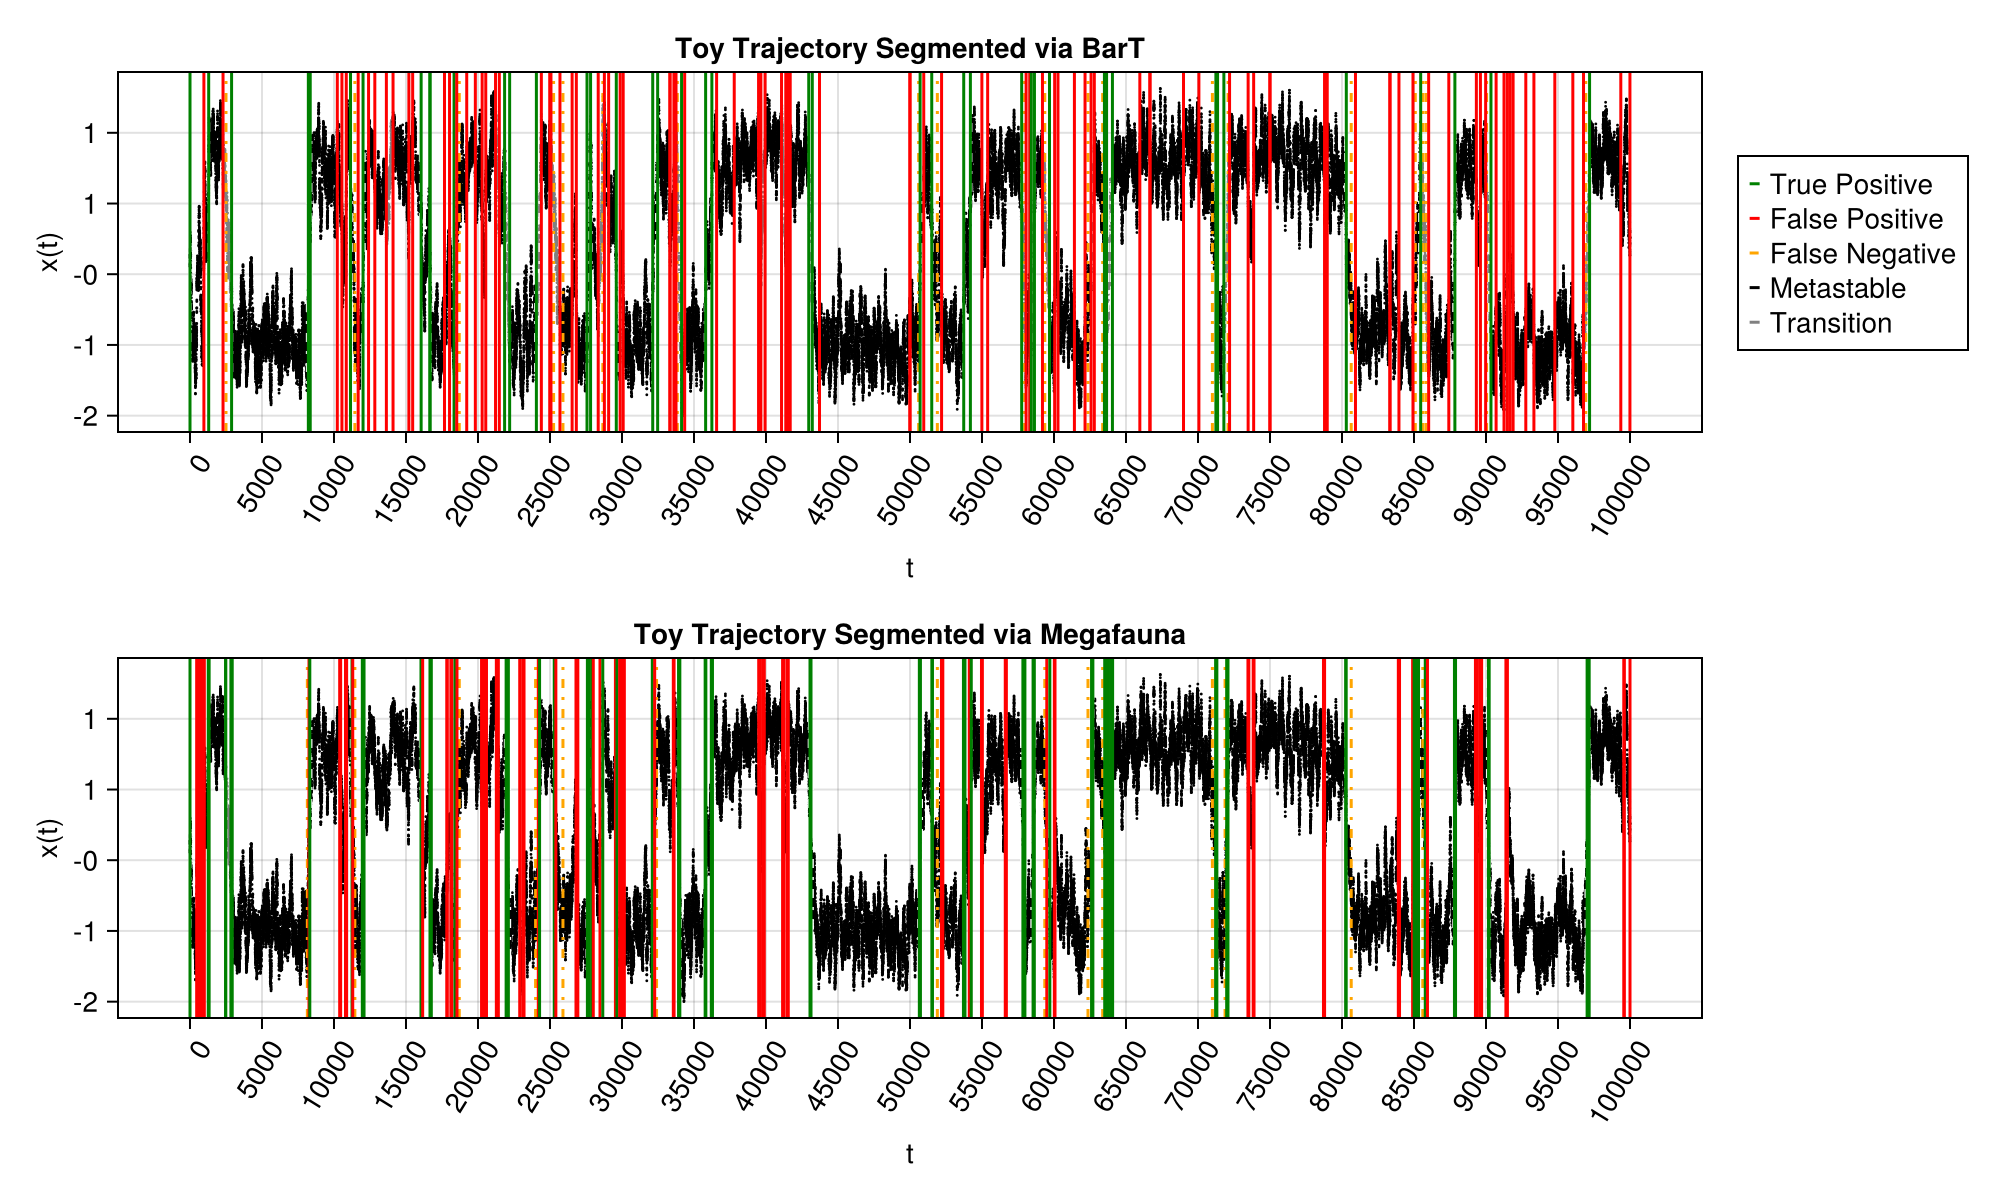

In [44]:
zzsfunction identify_transitions(X, cps)
    N = length(cps) - 1
    t1, t2, t3, t4 = cps[1], cps[2], cps[3], cps[4]
    predecessor = X[t1:t2]
    current = X[t2:t3]
    successor = X[t3:t4]
    m_pred, σ_pred = median(predecessor), std(predecessor)
    m_curr, σ_curr = median(current), std(current)
    m_succ, σ_succ = median(successor), std(successor)
    transition_labels = zeros(N)
    mstable_stats = zeros(N)
    trans_stats = zeros(N)
    for i = 2:N-1
        metalike = 0
        translike = 0
        L = length(current)
        for (idx, x) in enumerate(current)
            λ = idx / (L + 1)
            μ = λ * median(successor) + (1 - λ) * median(predecessor)
            ρ = λ * std(successor) + (1 - λ) * std(predecessor)
            metalike -= log(2* σ_curr) + (abs(x - m_curr) / σ_curr)
            translike -= log(2 * ρ) + (abs(x - μ) / ρ)
        end
        mstable_stats[i] = metalike 
        trans_stats[i] = translike
        transition_labels[i] = metalike > translike ? 0 : 1
        if i == N - 1
            break
        end
        predecessor = current
        current = successor
        successor = X[cps[i+2]:cps[i+3]]
        m_pred, σ_pred = m_curr, σ_curr
        m_curr, σ_curr = m_succ, σ_succ
        m_succ, σ_succ = median(successor), std(successor)
    end
    return (transition_labels, mstable_stats, trans_stats)
end

function kstest(X, cps, segment_labels)
    N = length(cps) - 1
    laplace_pvalues = []
    normal_pvalues = []
    mstable_lengths = []
    n_mstable = 0
    
    for i=1:N
        if segment_labels[i] > 0
            continue
        end
        n_mstable += 1
        segment = X[cps[i]:cps[i+1]]
        push!(mstable_lengths, length(segment))
        Z = fit_mle(Laplace, segment)
        Zprime = fit_mle(Normal, segment)
        push!(laplace_pvalues, pvalue(ExactOneSampleKSTest(segment, Z)))
        push!(normal_pvalues, pvalue(ExactOneSampleKSTest(segment, Zprime)))
    end
    laplace_reject_rate = 1 - (count(>(0.05), laplace_pvalues)) / n_mstable 
    normal_reject_rate = 1 - (count(>(0.05), normal_pvalues)) / n_mstable 

    return (laplace_pvalues, normal_pvalues, laplace_reject_rate, normal_reject_rate)
    
end

function change_point_F1(cps, true_cps; tolerance=50)
    println(tolerance)
    positives = [any(abs.(true_cps .- x) .< tolerance) for x in cps]
    true_positives = count(==(1), positives)
    # if the closest detected change point is more than tolerance away, you missed the change point
    false_positives = count(==(0), positives)
    negatives = [minimum(abs.(cps .- x)) .> tolerance for x in true_cps] 
    false_negatives = count(==(1), negatives)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    F1 = 2 * (precision * recall) / (recall + precision)
    return (recall, precision, F1, positives, negatives)
end

function transition_F1(point_labels, true_labels)
    arr = cat(point_labels, true_labels, dims=2)
    TP, FP, FN = 0, 0, 0
    for row in eachrow(arr)
        if row[1] == 1 && row[2] == 1
            TP += 1
        elseif row[1] == 1 && row[2] == 0
            FP += 1
        elseif row[1] == 0 && row[2] == 1
            FN += 1
        else
            continue
        end
    end
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)
    return (recall, precision, F1)
end





function plot_trajectories_with_change_points(
        X,
        bart_cps, bart_point_labels, bart_positives, bart_negatives,
        mf_cps, mf_point_labels, mf_positives, mf_negatives,
        true_cps, true_point_labels)
    fig_size = (1000,600)
    fig = Figure(size=fig_size)
    cmap=Makie.Categorical(:darktest)
    cmap_segs = Makie.Categorical(:darktest)
    
    ymin, ymax, ystep = minimum(X), maximum(X), 0.75
    ax1 = Axis(fig[1,1])
    ax2 = Axis(fig[2,1])
    ax1.title="Toy Trajectory Segmented via BarT"
    ax2.title="Toy Trajectory Segmented via Megafauna"
    ax1.xlabel = ax2.xlabel = "t"
    ax1.ylabel = ax2.ylabel = "x(t)"
    ax1.xticks = ax2.xticks = 0:5000:length(X)
    ax1.xticklabelrotation=ax2.xticklabelrotation=45.0
    
    ax1.yticks = ax2.yticks = ymin:ystep:ymax
    ax1.xtickformat = ax2.xtickformat = "{:.0f}"
    ax1.ytickformat = ax2.ytickformat = "{:.0f}"


    mf_colors = map(b -> b > 0 ? :gray : :black, mf_point_labels)
    bart_colors = map(b -> b > 0 ? :gray : :black, bart_point_labels)
    mf_positives_colors = map(b -> b > 0 ? :green : :red, mf_positives)
    bart_positives_colors = map(b -> b > 0 ? :green : :red, bart_positives)
    mf_negatives_colors = map(b -> b > 0 ? :orange : :white, mf_negatives)
    bart_negatives_colors = map(b -> b > 0 ? :orange : :white, bart_negatives)


    scatter!(ax1, 1:length(X), X[:,1], color=bart_colors, markersize=2)
    scatter!(ax2, 1:length(X), X[:,1], color=mf_colors, markersize=2)

    println(size(bart_negatives))
    vlines!(ax1, true_cps[:,1], color=bart_negatives_colors[:,1], linestyle=:dashdot, colormap=cmap)
    vlines!(ax1, bart_cps[:,1], color=bart_positives_colors[:,1], linestyle=:solid, colormap=cmap)
    vlines!(ax2, true_cps[:,1], color=mf_negatives_colors[:,1], linestyle=:dashdot, colormap=cmap)
    vlines!(ax2, mf_cps[:,1], color=mf_positives_colors[:,1], linestyle=:solid, colormap=cmap)
    
    elem_1 = [LineElement(color = :green, linestyle = :solid)]
    elem_2 = [LineElement(color = :red, linestyle = :solid)]
    elem_3 = [LineElement(color = :orange, linestyle = :dashdot)]
    elem_4 = [LineElement(color = :black, linestyle = nothing)]
    elem_5 = [LineElement(color = :gray, linestyle = nothing)]
    
    Legend(fig[1,2],
        [elem_1, elem_2, elem_3, elem_4, elem_5],
        ["True Positive", "False Positive", "False Negative","Metastable", "Transition"],
        patchsize = (5, 5), rowgap = 1, position=:lt)
    return fig
    
end

function color_by_frequency(l)
    # Get frequency counts of each label
    freq = countmap(l)
    
    # Sort labels by frequency (most frequent first)
    sorted_labels = sort(collect(keys(freq)), by=x->freq[x], rev=true)
    println(freq)
    
    # Create a color map with blue, green, red for top 3 frequencies
    colors = Dict(
        sorted_labels[1] => :blue,
        sorted_labels[2] => :green,
        sorted_labels[3] => :red
    )
    
    # For any additional labels, they get gray
    for i in 4:length(sorted_labels)
        colors[sorted_labels[i]] = :gray
    end
    
    # Plot with the appropriate colors

    return color=[colors[label] for label in l]
end

function plot_clustered_trajectories(
        X,
        bart_cps, bart_point_labels, #bart_positives, bart_negatives,
        mf_cps, mf_point_labels, #mf_positives, mf_negatives,
        true_cps, true_point_labels)
    fig_size = (1000,600)
    fig = Figure(size=fig_size)
    cmap=Makie.Categorical(:darktest)
    cmap_segs = Makie.Categorical(:darktest)
    
    ymin, ymax, ystep = minimum(X), maximum(X), 0.75
    ax1 = Axis(fig[1,1])
    ax2 = Axis(fig[2,1])
    ax3 = Axis(fig[3,1])
    ax1.title="Toy Trajectory Segmented via BarT"
    ax2.title="Toy Trajectory Segmented via Megafauna"
    ax3.title="Toy Trajectory Segmented via Ground Truth"

    ax1.xlabel = ax2.xlabel = ax3.xlabel = "t"
    ax1.ylabel = ax2.ylabel = ax3.ylabel ="x(t)"
    ax1.xticks = ax2.xticks = ax3.xticks =0:5000:length(X)
    
    ax1.yticks = ax2.yticks = ax3.yticks =ymin:ystep:ymax
    ax1.xtickformat = ax2.xtickformat = ax3.xtickformat = "{:.0f}"
    ax1.ytickformat = ax2.ytickformat = ax3.ytickformat = "{:.0f}"

    scatter!(ax1, 1:length(X), X[:,1], color=color_by_frequency(bart_point_labels[:,1]), colormap=:rainbow, markersize=2)
    scatter!(ax2, 1:length(X), X[:,1], color=color_by_frequency(mf_point_labels[:,1]), colormap=:rainbow, markersize=2)
    scatter!(ax3, 1:length(X), X[:,1], color=color_by_frequency(true_point_labels[:,1]), colormap=:rainbow, markersize=2)


    #vlines!(ax1, true_cps[:,1], color=bart_negatives_colors[:,1], linestyle=:dashdot, colormap=cmap)
    #vlines!(ax1, bart_cps[:,1], color=bart_positives_colors[:,1], linestyle=:solid, colormap=cmap)
    #vlines!(ax2, true_cps[:,1], color=mf_negatives_colors[:,1], linestyle=:dashdot, colormap=cmap)
    #vlines!(ax2, mf_cps[:,1], color=mf_positives_colors[:,1], linestyle=:solid, colormap=cmap)
    
    elem_1 = [LineElement(color = :blue, linestyle = :solid)]
    elem_2 = [LineElement(color = :green, linestyle = :solid)]
    elem_3 = [LineElement(color = :red, linestyle = :solid)]
    #elem_4 = [LineElement(color = :black, linestyle = nothing)]
    #elem_5 = [LineElement(color = :gray, linestyle = nothing)]
    
    Legend(fig[2, 2], [elem_1, elem_2, elem_3], ["Largest pop.", "2nd Largest Pop.", "3rd Largest pop."])
    return fig
    
end

function cpq_score(cps, true_cps)
    return norm([minimum(abs.(true_cps .- x)) for x in cps])
end

function plot_pvalue_hist(pvalues1, pvalues2, method_name)
    fig = Figure(size=(1000, 500))
    ax1 = Axis(fig[1,1])
    ax2 = Axis(fig[1,2])
    ax1.title="Distribution of P Values for Kolmogorov Smirnov Test \n Segmentation Method: $(method_name), Prior: Laplace"
    ax2.title="Distribution of P Values for Kolmogorov Smirnov Test \n Segmentation Method: $(method_name), Prior: Gaussian"
    ax1.xticks = ax2.xticks = 0:0.05:1.
    ax1.xtickformat = ax2.xtickformat = "{:.2f}"
    ax1.xticklabelrotation = ax2.xticklabelrotation=45.0

    hist!(ax1, pvalues1, bins=25)
    hist!(ax2, pvalues2, bins=25)
    return fig
    
end


function cp_pipeline(X, bart_cps, true_cps; tolerance=1)
    true_segment_lenghts = [true_cps[i+1] - true_cps[i] + 1 for i=1:length(true_cps) - 1]
    windowsize = 225 #minimum(true_segment_lenghts[true_segment_lenghts .> 2])
    quant = 0.86
    mf_deriv = compute_metric_wasserstein_derivative(X, windowsize, sqeuclidean)[:,1]
    mf_cps = compute_change_points(X, quant, windowsize)
    bart_cps[1] = 1
    true_cps[1] = 1
    #println("Megafauna Relative Error: $(norm(true_cps - mf_cps) / norm(true_cps))")
    println(cpq_score(bart_cps, true_cps))
    println(cpq_score(mf_cps, true_cps))
    #println("Megafauna Absolute Error: $(norm(true_cps - mf_cps))")


    # identify transitions
    segment_transition_labels, segment_mstable_stats, segment_trans_stats = identify_transitions(X, true_cps);
    mf_segment_transition_labels, mf_segment_mstable_stats, mf_segment_trans_stats = identify_transitions(X, mf_cps);
    bart_segment_transition_labels, bart_segment_mstable_stats, bart_segment_trans_stats = identify_transitions(X, bart_cps);

    # label points
    point_labels = label_series(X, true_cps, segment_transition_labels);
    bart_point_labels = convert(Vector{Float64},label_series(X, bart_cps, bart_segment_transition_labels));
    mf_point_labels = convert(Vector{Float64}, label_series(X, mf_cps, mf_segment_transition_labels));
        
    # analyze segments with KS Test, return distributions of p-values
    mf_pdata = kstest(X, mf_cps, mf_segment_transition_labels)
    bart_pdata = kstest(X, bart_cps, bart_segment_transition_labels)

    mf_pvalue_hist = plot_pvalue_hist(mf_pdata[1], mf_pdata[2], "Megafauna")
    save("megafauna-pvalues-langevin.png", mf_pvalue_hist)
    bart_pvalue_hist = plot_pvalue_hist(bart_pdata[1], bart_pdata[2],  "BarT")
    save("bart-pvalues-langevin.png", bart_pvalue_hist)

    # compute F1 scores for change points
    bart_cp_recall, bart_cp_precision, bart_cp_F1, bart_positives, bart_negatives = change_point_F1(bart_cps, true_cps, tolerance=tolerance)
    mf_cp_recall, mf_cp_precision, mf_cp_F1, mf_positives, mf_negatives = change_point_F1(mf_cps, true_cps, tolerance=tolerance)
    println("*************Change Point F1**************")
    println("BarT")
    println(bart_cp_recall, " ",bart_cp_precision, " ",bart_cp_F1)
    println("MF")
    println(mf_cp_recall," ", mf_cp_precision," ", mf_cp_F1)
    # compute F1 scores for metastable vs transition
    bart_transition_recall, bart_transition_precision, bart_transition_F1 = transition_F1(bart_point_labels, point_labels)
    mf_transition_recall, mf_transition_precision, mf_transition_F1 = transition_F1(mf_point_labels, point_labels)
    println("*************Transition F1**************")
    println("BarT")
    println(bart_transition_recall, " ",bart_transition_precision, " ",bart_transition_F1)
    println("MF")
    println(mf_transition_recall," ", mf_transition_precision," ", mf_transition_F1)
    # cluster segments with DPC, return clustering and decision graph

    # generate figures
    fig = plot_trajectories_with_change_points(
        X,
        bart_cps, bart_point_labels, bart_positives, bart_negatives,
        mf_cps, mf_point_labels, mf_positives, mf_negatives,
        true_cps, point_labels
    )
    #save("toy-data-$(σ)-$(trans)-transition-ids.png", fig)
    println(size(mf_cps), size(bart_cps), size(true_cps))
    #println(abs.(mf_cps - true_cps))
    return fig
end


cp_pipeline(X, bart_cps, true_cps;tolerance=100)

In [18]:
function draw_decision_graph(D; q=0.02, seg_lengths=nothing)
    N, _ = size(D)
    dc = quantile!([D[i,j] for i=1:N, j=1:N if i > j], q)
    if isnothing(seg_lengths)
        ρ = hcat(collect(1:N), [length(row[row .<= dc]) for row in eachrow(D)])
    else
        ρ = hcat(collect(1:N), [sum(seg_lengths .* exp.(-(D[i,:] / dc).^2)) for i in 1:N])
    end
    δ = zeros(N)
    nearest_denser_neighbor = zeros(N)
    for i=1:N
        indices = convert(Array{Int32},filter!(idx -> idx ∉ [i], ρ[ρ[:,2] .>= ρ[i, 2],:][:,1]))
        if length(indices) > 0
            δ[i] = minimum(D[indices, i])
            nearest_denser_neighbor[i] = argmin(D[indices, i])
        else
            δ[i] = maximum(D[:,i])
            nearest_denser_neighbor[i] = i
        end
    end
    γ = ρ[:,2] .* δ
    fig = Figure(size=(1000, 500))
    ax1 = Axis(fig[1,1], title="ρ-δ Plot", xlabel="ρ", ylabel="δ")
    ax2 = Axis(fig[1,2], title="γ Plot", xlabel="Rank", ylabel="γ")
    scatter!(ax1, ρ[:,2], δ)
    scatter!(ax2, 1:length(γ), sort!(γ))
    fig
end

function label_by_density_peaks(D, K; q=0.1, seg_lengths=nothing)
    N, _ = size(D)
    dc = quantile!([D[i,j] for i=2:N, j=1:N if i > j], q)
    if isnothing(seg_lengths)
        ρ = hcat(collect(1:N), [length(row[row .<= dc]) for row in eachrow(D)])
    else
        ρ = hcat(collect(1:N), [sum(seg_lengths .* exp.(-(D[i,:] / dc).^2)) for i in 1:N])
    end
    δ = zeros(N)
    nearest_denser_neighbor = zeros(N)
    for i=1:N
        indices = convert(Array{Int32},filter!(idx -> idx ∉ [i], ρ[ρ[:,2] .>= ρ[i, 2],:][:,1]))
        if length(indices) > 0
            δ[i] = minimum(D[indices, i])
            nearest_denser_neighbor[i] = argmin(D[indices, i])
        else
            δ[i] = maximum(D[:,i])
            nearest_denser_neighbor[i] = i
        end
    end
    γ = ρ[:,2] .* δ
    centers = sortperm(γ, rev=true)[1:K]

    
    labs = fill(-1, N)  # Initialize labels array with -1
    for (i, center) in enumerate(centers)
        labs[center] = i - 1  # Julia uses 1-based indexing, so adjust accordingly
    end
    index_rho = sortperm(ρ[:,2], rev=true)
    for index in index_rho
        if labs[index] == -1
            labs[index] = labs[nearest_denser_neighbor[index]]
        end
    end
    return labs

    return labs
end

label_by_density_peaks (generic function with 1 method)

In [12]:
save("BarT-Langevin-Decision-Graph.png", draw_decision_graph(BarTD))
save("MF-Langevin-Decision-Graph.png", draw_decision_graph(MFD))
save("BarT-Langevin-Decision-Graph-segment-scaled.png", draw_decision_graph(BarTD, seg_lengths=[bart_cps[T+1] - bart_cps[T] for T in 1:length(bart_cps) - 1]))
save("MF-Langevin-Decision-Graph-segment-scaled.png", draw_decision_graph(MFD, seg_lengths=[cps[T+1] - cps[T] for T in 1:length(cps) - 1]))

CairoMakie.Screen{IMAGE}


In [13]:
segment_lengths = [bart_cps[T+1] - bart_cps[T] for T in 1:length(bart_cps) - 1]

idx = sortperm(segment_lengths, rev=true);
fig = Figure(size=(1500, 1500))
for i = 1:3
T = idx[i]
segment = X[bart_cps[T]:bart_cps[T+1]]
U = fit_mle(Normal, segment)
V = fit_mle(Laplace, segment)
W = fit_mle(Uniform, segment)
Uks = ExactOneSampleKSTest(segment, U)
Vks = ExactOneSampleKSTest(segment, V)
Wks = ExactOneSampleKSTest(segment, W)
t = collect(range(minimum(segment), maximum(segment), length=1000))
ax = Axis(fig[i,1], title="Kolmogorov-Smirnov Test for segment #$(T)\n# Samples: $(length(segment))\nHypothesis: Laplace Distribution\np-value: $(round(pvalue(Vks),digits=3))", ylabel="CDF")
ax2 = Axis(fig[i,2], title="Kolmogorov-Smirnov Test for segment #$(T)\n# Samples: $(length(segment))\nHypothesis: Normal Distribution\np-value: $(round(pvalue(Uks),digits=3))", ylabel="CDF")
ax3 = Axis(fig[i,3], title="Kolmogorov-Smirnov Test for segment #$(T)\n# Samples: $(length(segment))\nHypothesis: Uniform Distribution\np-value: $(round(pvalue(Wks),digits=3))", ylabel="CDF")
lines!(ax, t, cdf.(V,t), color="blue")
lines!(ax, sort(segment), (1:length(segment))./length(segment),color="red")
lines!(ax2, t, cdf.(U,t), color="blue")
lines!(ax2, sort(segment), (1:length(segment))./length(segment),color="red")
lines!(ax3, t, cdf.(W,t), color="blue")
lines!(ax3, sort(segment), (1:length(segment))./length(segment),color="red")
end
current_figure()
save("langevin-ks-test.png", fig)
save("langevin-ks-test.pdf", fig)


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/4N1Zy/src/kolmogorov_smirnov.jl:68


CairoMakie.Screen{PDF}


In [14]:
function density_peaks_clustering(D; q=0.01, segment_lengths=nothing, num_clusters=nothing, filename="decision-graph-gamma-curve.png")
    N, _ = size(D)
    dc = quantile!([D[i,j] for i=2:N, j=1:N if i > j], q)
    if isnothing(segment_lengths)
        ρ = [length(row[row .<= dc]) for row in eachrow(D)]
    else
        ρ = [sum(segment_lengths .* exp.(-(D[i,:] ./ dc).^2)) for i in 1:N]
    end
    δ = zeros(N)
    nearest_denser_neighbor = zeros(N)
    for i=1:N
        denser_indices = findall(ρ .> ρ[i])
        if length(denser_indices) > 0
            dists = D[denser_indices, i]
            δ[i] = minimum(dists)
            nearest_denser_neighbor[i] = argmin(dists)
        else
            δ[i] = maximum(D[:,i])
            nearest_denser_neighbor[i] = i
        end
    end

    γ = sort(ρ .* δ)
    
    fig = Figure(size=(1000, 500))
    ax1 = Axis(fig[1,1], title="ρ-δ Plot", xlabel="ρ", ylabel="δ")
    ax2 = Axis(fig[1,2], title="γ Plot", xlabel="Rank", ylabel="γ")
    scatter!(ax1, ρ, δ)
    scatter!(ax2, 1:length(γ), sort!(γ))
    save(filename, fig)
    
    if isnothing(num_clusters)
        γ_curvature = [γ[i + 1] + γ[i - 1] - 2γ[i] for i=2:N-1]
        pushfirst!(γ_curvature, 0)
        push!(γ_curvature, 0)
        K = N - argmax(γ_curvature)
    else
        K = num_clusters
    end
    println("Guessing that there are $(K) clusters")

    labels = fill(-1, N)
    sorted_ρ_indices = sortperm(ρ, rev=true)
    centers = sorted_ρ_indices[1:K]
    println(centers)
    for i=1:K
        labels[centers[i]] = i
    end

    for i=(K+1):N
        denser_points = sorted_ρ_indices[1:i-1]
        idx = argmin(D[denser_points,sorted_ρ_indices[i]])
        labels[sorted_ρ_indices[i]] = labels[denser_points[idx]]
    end
    
    return labels
end

density_peaks_clustering (generic function with 1 method)

5.433340272916716e-5
4.084912281856958e-5


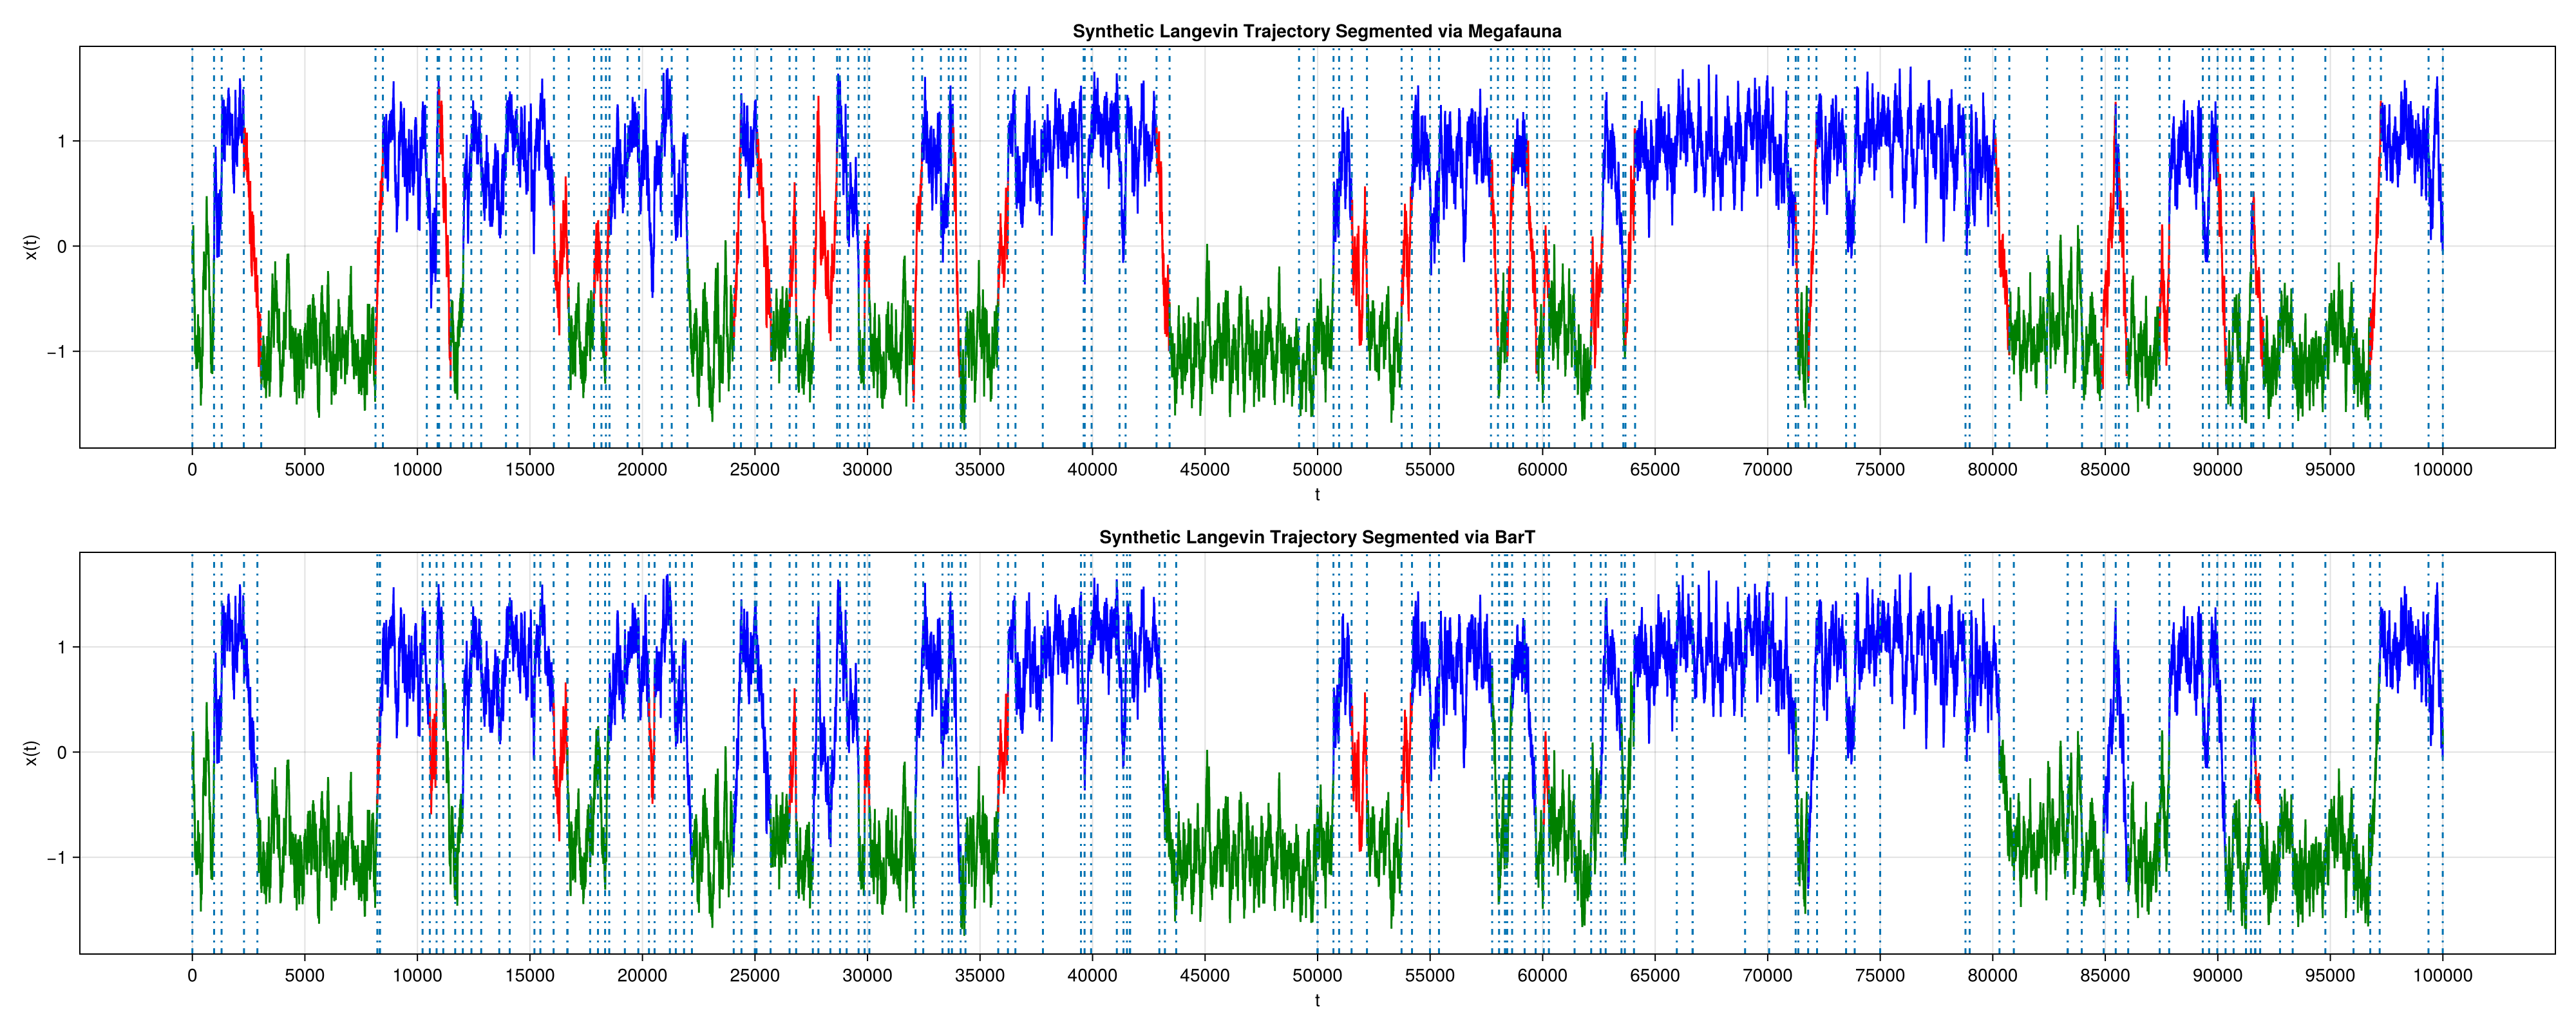

In [23]:
q=0.02
K=3
mf_segment_lengths = [cps[T+1] - cps[T] for T in 1:length(cps) - 1]
bart_segment_lengths = [bart_cps[T+1] - bart_cps[T] for T in 1:length(bart_cps) - 1]

#bart_labels = label_series(X, bart_cps, density_peaks_clustering(BarTD, segment_lengths=bart_segment_lengths, num_clusters=K));
#mf_labels = label_series(X, cps, density_peaks_clustering(MFD, segment_lengths = mf_segment_lengths, num_clusters=K));
bart_segment_labels = get_clusters(X, bart_cps, BarTD, K)
mf_segment_labels = get_clusters(X, cps, MFD, K)
bart_labels = label_series(X, bart_cps, bart_segment_labels)
mf_labels = label_series(X, cps, mf_segment_labels)

using StatsBase
fig_size = (2000,800)
fig = Figure(size=fig_size)
cmap=Makie.Categorical(:darktest)

bart_freq = countmap(bart_labels)
sorted_bart_labels = sort(collect(keys(bart_freq)), by=x->bart_freq[x], rev=true)
bart_colors = Dict(
        sorted_bart_labels[1] => :blue,
        sorted_bart_labels[2] => :green,
        sorted_bart_labels[3] => :red
)
bart_colored_labels = [bart_colors[label] for label in bart_labels]

mf_freq = countmap(mf_labels)
sorted_mf_labels = sort(collect(keys(mf_freq)), by=x->mf_freq[x], rev=true)
mf_colors = Dict(
        sorted_mf_labels[1] => :blue,
        sorted_mf_labels[2] => :green,
        sorted_bart_labels[3] => :red
)
mf_colored_labels = [mf_colors[label] for label in mf_labels]

ax1 = Axis(fig[1,1])
ax1.title="Synthetic Langevin Trajectory Segmented via Megafauna"
ax1.xlabel="t"
ax1.ylabel="x(t)"
ax1.xticks=0:5000:100000
ax1.xtickformat="{:.0f}"
ax1.yticks=-1:1:1
lines!(ax1, 1:100000, X[:,1], color=mf_colored_labels)
vlines!(ax1,cps[:,1], linestyle=:dashdot)

ax2 = Axis(fig[2,1])
ax2.title="Synthetic Langevin Trajectory Segmented via BarT"
ax2.xlabel="t"
ax2.ylabel="x(t)"
ax2.xticks=0:5000:100000
ax2.xtickformat="{:.0f}"
ax2.yticks=-1:1:1
lines!(ax2, 1:100000, X[:,1], color=bart_colored_labels)
vlines!(ax2,bart_cps[:,1], linestyle=:dashdot)
fig
save("clustered-langevin-$(K).png", fig)

current_figure()

In [10]:
s = cps[1]
t = cps[2]
collect(s:t)\X[s:t]

-0.000894976405817453

In [11]:
using LinearRegression

In [12]:
lr = linregress(collect(s:t), X[s:t])

LinearRegression.LinearRegressor{Vector{Float64}}(true, [0.00021923783222316172, -0.7156969455680883])

In [13]:
LinearRegression.slope(lr)

1-element view(::Vector{Float64}, 1:1) with eltype Float64:
 0.00021923783222316172

In [32]:
sample_mean(segment) = sum(segment) / length(segment)
slope(segment) = LinearRegression.slope(linregress(collect(1:length(segment)), segment))[1]
bias(segment) = LinearRegression.slope(linregress(collect(1:length(segment)), segment))[1]
L(segment) = (slope(segment) .* collect(1:length(segment))) .+ bias(segment)
residuals(segment) = segment .- L(segment)
residuals(segment) = sample_mean(segment) .- segment
#residuals(X[s:t])
σ(segment) = std(residuals(segment))
σ_slope(segment) = σ(segment) / norm(segment .- sample_mean(segment))
#slope(segment) = LinearRegression.slope(linregress(collect(1:length(segment)), segment))[1]
is_transition(segment) = abs(slope(segment)) > 1.96 * σ_slope(segment)
#is_transition(X[s:t])

is_transition (generic function with 2 methods)

In [48]:
bart_slopes = [slope(X[cps[i]:cps[i+1]]) for i in 1:(length(bart_cps) - 1)]
bart_σ_slopes = [σ_slope(X[cps[i]:cps[i+1]]) for i in 1:(length(bart_cps) - 1)]
bart_transition_labels = [is_transition(X[bart_cps[i]:bart_cps[i+1]]) for i in 1:(length(bart_cps)-1)]
mf_transition_labels = [is_transition(X[cps[i]:cps[i+1]]) for i in 1:(length(cps)-1)]
any(bart_transition_labels)

false

In [51]:
function is_transition(s, t, segment)
    sample_mean = sum(segment) / length(segment)
    lr = linregress(collect(s:t), segment)
    m, b = LinearRegression.slope(lr)[1], LinearRegression.bias(lr)[1]
    #println(m) 
    #println(b)
    line = m .* collect(s:t) .+ b
    residuals = segment .- line
    σ = std(residuals)
    σ_slope = σ / norm(segment .- sample_mean)
    return abs(m) > 1. * σ_slope
end

bart_transition_labels = [is_transition(bart_cps[i], bart_cps[i+1], X[bart_cps[i]:bart_cps[i+1]]) for i in 1:(length(bart_cps)-1)]
any(bart_transition_labels)

false

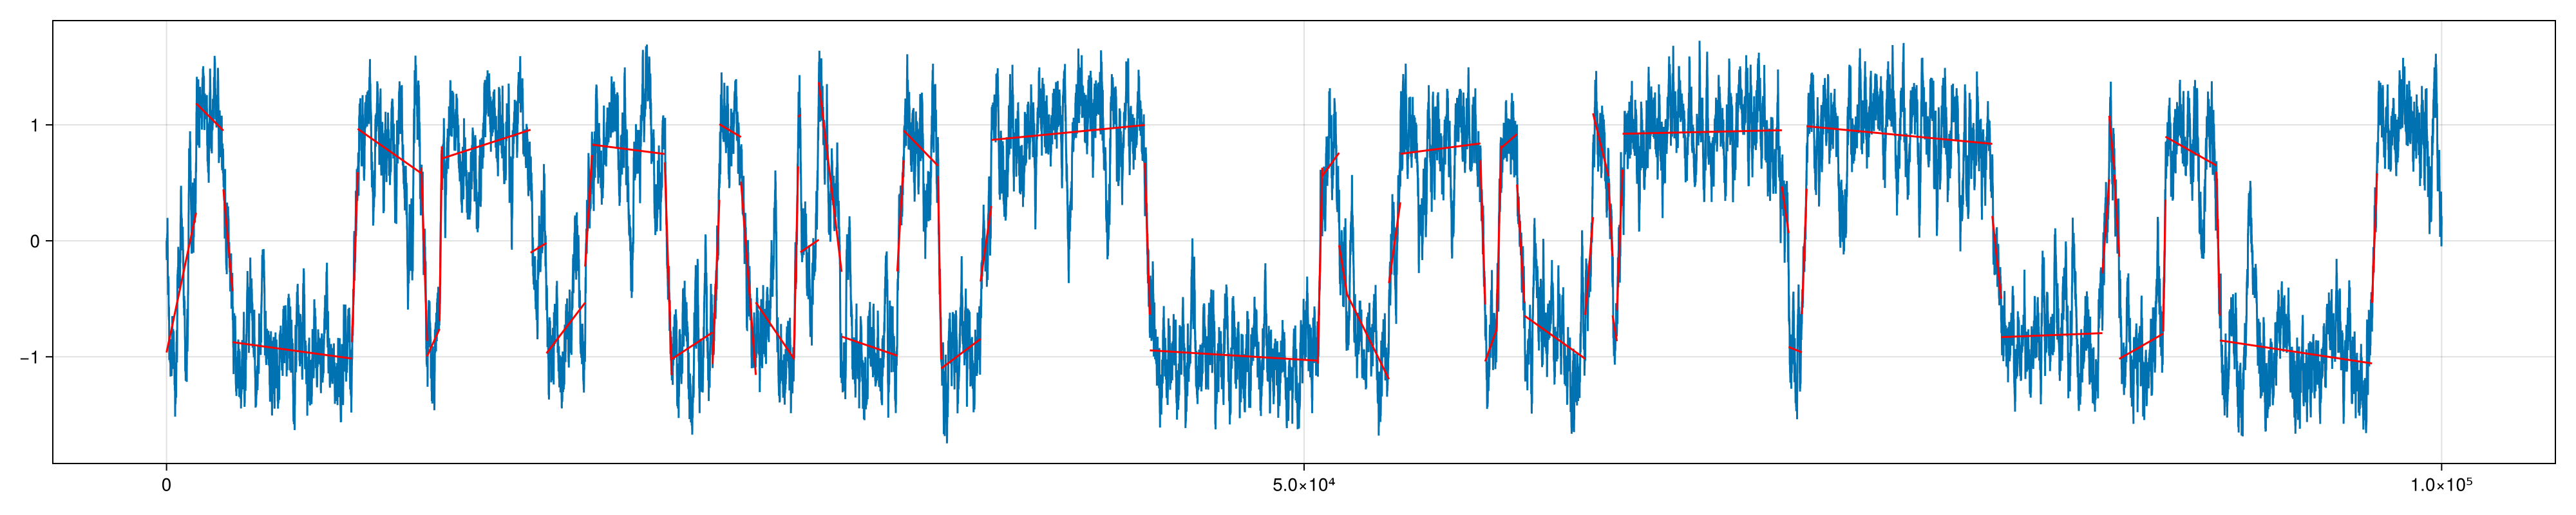

In [43]:
fig = Figure(size=(2000,400))
ax = Axis(fig[1,1])
lines!(ax,collect(1:length(X[:,1])), X[:,1])
for i=1:(length(bart_cps) - 1)
    s = bart_cps[i]
    t = bart_cps[i + 1]
    lr = linregress(collect(s:t), X[s:t])
    m = LinearRegression.slope(lr)
    b = LinearRegression.bias(lr)
    x = collect(s:t)
    y = (m .* x) .+ b
    lines!(ax, x, y, color="red")
    #lines!(ax,x,L(X[s:t]),color="red")
end
current_figure()